# Exercise Sheet 6: Vision Transformers in Foundation Models and Self Supervised Learning

- Deep Learning for Computer Vision - Winter Term 2024/25
- Lecture by: Constantin Pape
- Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
- Due date: Tuesday, Jan 28, before 10:00

In this exercise, we will use pre-trained vision-language models introduced by [SigLIP](https://arxiv.org/abs/2303.15343).
These models can solve different vision-language tasks. Here, we will use them for classification using two different approaches:
- zero-shot and prompt-based classification with the English and the multi-lingual SigLIP (mSigLIP) model.
- finetuning SigLIP for multi-label classification.

## Time required to solve this exercise sheet

**You will train a model with a lot of parameters in this exercise, which will require some time. We recommend to start working on this sheet early.**

## Topic:

In this exercise sheet, you will:
- get to know about language-image pretrained (LIP) models
- use models from SigLIP for zero-shot and prompt-based classification.
- use the SigLIP multiingual model.
- finetune SigLIP for multi-label classification.

*We are looking forward to seeing your solutions! Have fun!*

## IMPORTANT SUBMISSION INSTRUCTIONS
- **You need to answer all the questions in written form.**
- When you're done, download the notebook and **rename** it to `<surname1>_<surname2>_<surname3>.ipynb`.
- Only submit the Jupyter Notebook (.ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 6` -> `Tutorial X` (where, `X` is the tutorial you are assigned to).
- Make only one submission of the exercise per group.
- The deadline is strict
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand.

## Setup and Requirements

### Installing Relevant Dependencies

In [ ]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers sentencepiece datasets

### Importing Libraries

In [ ]:
import os
import requests
from tqdm.auto import tqdm
from typing import List, Union

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import kagglehub

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

from transformers import (
    pipeline, AutoProcessor, AutoModel, AutoImageProcessor, AutoModelForImageClassification
)

## SigLIP: Sigmoid Loss for Language Image Pre-Training

Language image pretraining has been popularized by [CLIP](https://arxiv.org/abs/2103.00020) (Contrastive Language-Image Pre-training - https://openai.com/index/clip/).
CLIP uses a contrastive loss function (similar to the ones discussed in lecture 11 for self-supervised learning) that is formulated between image and text pairs. Intuitively, the goal of this loss function is to bring embeddings derived from an image and the matching caption close to each other, and to push embeddings for images and captions that are not matching apart from each other.
To train it, the team behind CLIP has collected a dataset of 400 million image and text (caption) pairs from the internet.
The architecture of CLIP is simple: it consists of an image encoder and text encoder (both transformer-based).

After training, CLIP can be used for different text-language tasks, for example text-prompt based classification. The large training dataset and combination of image and text data makes it quite flexible and robust. For example, it can classify objects from ImageNet under different object representations (e.g. sketches, image distortions, etc.) much more robustly than models trained on normal ImageNet:

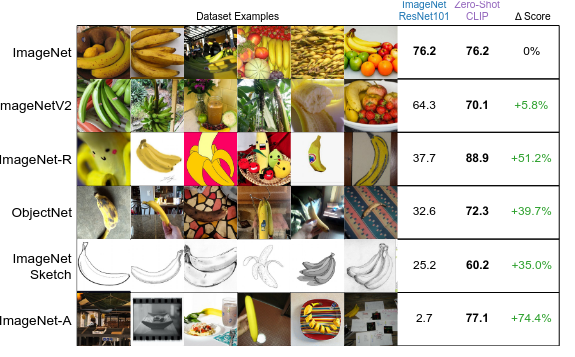

[SigLIP](https://arxiv.org/abs/2303.15343) has updated the training procedure of CLIP by replacing the soft-max in the contrastive loss function with a sigmoid. This seemingly simple change makes model training more efficient, as it removes any operation dependent on the training batch size. Intuitively, this changes the training objective to decide for each image-text pair if these belong together or not.
Thanks to the increased efficiency, the authors can train larger models for longer training times. The SigLIP models are now widely used for solving vision-language tasks and are an important foundation model.

### Zero Shot Classification

The first task is to use a SigLIP model for zero-shot classification. In this setting, we provide the model with an image and a number of text prompts, and the model will return a score ("How well does the prompt fit the image?") for each prompt.

NOTE: We load the best English SigLip model, which is the "shape-optimized (so)" architecture. Check out the [SigLIP publication](https://arxiv.org/abs/2305.13035) for details on the architecture.

In [ ]:
# Download a sample image from the COCO dataset.
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
# Visualize the sample image.
image

In [ ]:
# Load the pipeline, which supports running the image classification.
image_classifier = pipeline(
    task="zero-shot-image-classification",
    model="google/siglip-so400m-patch14-384",
    use_fast=True
)

# Run inference on our sample image using text prompts.
outputs = image_classifier(
    image,
    candidate_labels=["2 cats", "a plane", "a remote"]
)

# Get the confidence score for each corresponding text prompts.
outputs = [
    {"score": round(output["score"], 4), "label": output["label"]} for output in outputs
]

# Validate the predictions.
for output in outputs:
    print(output)

### Engineered Text Prompt-based Classification

We next load a different representation of the SigLIP model that allows a more fine-grained control of the model.

In [ ]:
# The device on which all inference and finetuning takes place.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model and the input processor using the Auto API (supported by "transformers" library)
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384", device_map=device)
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384", device_map=device)

#### Load image and texts

Let's use our current sample image and the corresponding CLIP-style prompts. The idea behind these prompts is to describe the classes for a classification task with simple sentences. For example, if we want to classify photos with two similar objects a corresponding prompt would be: `"a photo of 2 <objects>"`, where `<objects>` is replaced by the name of object. The authors have found in CLIP that this style of prompting increases the accuracy, because full sentences are more similar to the training data, which contains image captions that typically consists of full sentences rather than a single noun. We can think of this approach as a simple version of prompt engineering. 

In [ ]:
# A bunch of input prompts chosen to verify the model's ability to understand the context.
texts = ["a photo of 2 cats", "a photo of 2 hamburgers", "a photo of 2 dogs"]

# NOTE: It's important that we pass `padding="max_length"` as that's how the model has been trained.
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

# Let's verify the input prompts and input image, both as tensors.
for k, v in inputs.items():
    print(k, v.shape)

# Move all inputs to device
inputs = {k: v.to(device) for k, v in inputs.items()}

#### Run Inference

Next, we perform a forward pass and get the `logits_per_image`. These indicate the unnormalized scores for each image-text pair.

As SigLIP has been trained using the sigmoid loss (rather than cross-entropy as with CLIP), we need to apply the sigmoid activation function on the logits to turn them into individual probabilities (unlike CLIP, where probabilities sum to 1).

In [ ]:
# Run the model inference.
with torch.no_grad():
    predictions = model(**inputs)

logits_per_image = predictions.logits_per_image
outputs = torch.sigmoid(logits_per_image) # these are the probabilities

# Visualize the model's performance on provided input prompts.
for i, text in enumerate(texts):
    print(f"{outputs[0][i]:.1%} that the provided image is '{texts[i]}'")

### Multilingual SigLIP (mSigLIP)

SigLIP supports model inference in different languages. Let's try prompt-based classification in a new language. Here is an example below in German.

In [ ]:
# Load the model and correspnding input processor using the Auto API (supported by "transformers" library)
model = AutoModel.from_pretrained("google/siglip-base-patch16-256-multilingual", device_map=device)
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-256-multilingual", device_map=device)

#### German

In [ ]:
# A bunch of input prompts (in German) chosen to verify the model's ability to understand the context.
# NOTE: The text prompts below are a rough translation from English!
texts = ["ein Foto mit 2 Katzen", "ein Foto mit zwei Hamburgern", "ein Foto mit zwei Hunden"]

# NOTE: It's important that we pass `padding="max_length"` as that's how the model has been trained.
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

# Let's verify the input prompts and input image, both as tensors.
for k, v in inputs.items():
    print(k, v.shape)

# Move all inputs to device
inputs = {k: v.to(device) for k, v in inputs.items()}

In [ ]:
# Run the model inference.
with torch.no_grad():
    predictions = model(**inputs)

logits_per_image = predictions.logits_per_image
outputs = torch.sigmoid(logits_per_image) # these are the probabilities

# Visualize the model's performance on provided input prompts.
for i, text in enumerate(texts):
    print(f"{outputs[0][i]:.1%} that the provided image is '{texts[i]}'")

**TODO**: Run inference on the sample image in three other langugages:

mSigLIP supports >100 languages, thanks to their training data WebLI (https://arxiv.org/abs/2209.06794). The task is to evaluate the classification in three different languages of your choice. You can use languages you are familiar with or use **DeepL** (https://www.deepl.com/en/translator) to translate the prompts.

In [ ]:
# TODO: Your code here.

**Question**:

- Do you see any differences between the languages you chose? Does one work better / worse?

### Evaluate SigLIP on a new dataset

Now, you should evaluate the SigLIP models quantitatively. For this, we will use `MLCD`, an open-source dataset for multi-label classification  from kaggle (https://www.kaggle.com/datasets/meherunnesashraboni/multi-label-image-classification-dataset). This dataset contains images with annotations for a total of 16 categories.

In [ ]:
# Download the MLCD dataset.
# NOTE: The download script below works, if you work with the exercise on Kaggle.
# Otherwise, please visit https://www.kaggle.com/datasets/meherunnesashraboni/multi-label-image-classification-dataset and download the dataset manually.
dataset_path = kagglehub.dataset_download('meherunnesashraboni/multi-label-image-classification-dataset')

In [ ]:
# Get the csv path with all details about the class labels, etc. to corresponding images.
csv_path = os.path.join(dataset_path, "multilabel_modified", "multilabel_classification(2).csv")

In [ ]:
# Check the stored tabular data with all relevant label details.
df = pd.read_csv(csv_path)
df.head()

In [ ]:
# Verify the available labels.
labels = list(df.columns)[2:]
print(labels)

In [ ]:
# Let's map all labels to corresponding ids.
id2label = {id: label for id, label in enumerate(labels)}
print(id2label)

#### Visualize some images from the `MLCD` dataset.

We first separate the dataset into a training and test split, which we will need later.

Then, you should visualize a few images and the corresponding image labels from the dataset to check that the daa was loaded correctly.

In [ ]:
# Create train-test splits.
# We preprocessing the dataframe and remove images which do not exist in the image folders.
data_df = df[
    df["Image_Name"].apply(lambda x: os.path.exists(os.path.join(dataset_path, "multilabel_modified", "images", x)))
].reset_index(drop=True)

# Split the dataframe into exclusive train and test splits.
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=40)

In [ ]:
# Visualize images from the new dataset.

# TODO: Visualize 8 images, you can change this if you want to look at more / fewer images
n_images = 8

for idx in range(len(test_df)):  # Iterate over each row to extract relevant information.
    item = test_df.iloc[idx]
    
    # Get the desired image filename.
    image_path = os.path.join(dataset_path, "multilabel_modified", "images", item["Image_Name"])
    image = Image.open(image_path).convert("RGB")  # Load the image

    # Get the corresponding labels.
    labels = item[2:].values.astype(np.float32)
    true_labels = [id2label[idx] for idx, label in enumerate(labels) if label == 1.0]
    
    # TODO: Your code here.
    
    
    break  # comment this out to visualize this for all images

**Question**
- Visualize the images and corresponding labels. Do they match?

#### Evaluate prompt-based classification performance for English and three different languages.

You should now compare the accuracy of zero-shot classification for `MLCD` with SigLIP and the different settings we already used qualitatively before: using the English model, comparing simple (single word) prompt and CLIP-style prompt, and using the multi-lingual model with three different languages.

Below is some code to get you started with these tasks. Please fill in the rest, based on the previous code for applying the SigLIP models, and then run the model evaluations.

In [ ]:
# Mapping labels to desired lanugages: The example below is done in German language only!
labels_german = {
    "motorcycle": "Motorrad", "truck": "Lastwagen", "boat": "Boot", "bus": "Bus",
    "cycle": "Fahrrad", "person": "Person", "desert": "Wüste", "mountains": "Berg",
    "sea": "See", "sunset": "Sonnenuntergang", "trees": "Baum", "sitar": "Sitar",
    "ektara": "Ektara", "flutes": "Flöte", "tabla": "Tabla", "harmonium": "Harmonium",
}

In [ ]:
def get_accuracy_and_classification_report(
    true_binary: List[Union[float, int]],
    predicted_binary: List[Union[float, int]],
    report: bool = False,
):
    acc = accuracy_score(true_binary, predicted_binary)

    if report:
        report = classification_report(
            np.array(true_binary),
            np.array(predicted_binary),
            target_names=list(id2label.values()),
            zero_division=0
        )
        return report
    
    return acc

In [ ]:
# Load the pipeline for zero-shot image classification
image_classifier = pipeline(
    task="zero-shot-image-classification",
    model="google/siglip-so400m-patch14-384",
    device_map=device
)

# SigLIP: Load the model and correspnding input processor using the Auto API (supported by "transformers" library)
model_siglip = AutoModel.from_pretrained("google/siglip-so400m-patch14-384", device_map=device)
processor_siglip = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384", device_map=device)

# mSigLIP: Load the model and correspnding input processor using the Auto API (supported by "transformers" library)
model_msiglip = AutoModel.from_pretrained("google/siglip-base-patch16-256-multilingual", device_map=device)
processor_msiglip = AutoProcessor.from_pretrained("google/siglip-base-patch16-256-multilingual", device_map=device)

# TODO: Run inference per image.
# Steps:
# 1. Load the input image.
# 2. Load the corresponding labels per image.
#   a. Convert the labels in english to the three languages of choice.
# 3. Run inference using SigLIP for zero-shot classification and check the model outputs.
# 4. Run inference using SigLIP by providing engineered text prompts in CLIP-style.
# 5. Run inference using SigLIP by providing engineered text prompts in three different languages in CLIP-style.

# HINT: For the predicted probabilities, use a threshold of 0.5. Remember this threshold as we will use this in future evaluations as well.

# TODO: Your code here.

print("Overall accuracy for zero-shot classification in English: ", get_accuracy_and_classification_report(...))
print("Overall accuracy for prompt-engineered classification in English: ", get_accuracy_and_classification_report(...))
print("Overall accuracy for prompt-engineered classification in German: ", get_accuracy_and_classification_report(...))

**Questions**:
- Comment on the observation above. Which inference method works better? (simple prompt or prompt-engineered classification). Does the result match your expectation?
- Comment on your observation of the model's performance on the three different languages.

## Finetuning SigLIP for Multi-Label Image Classification

Now, we will finetune SigLIP for multi-label image classification on `MLCD`, using the previously defined training split.

We have prepared some code for this below. You should complete it to enable finetuning of the model, then run the finetuning task, and evaluate the model on the test split in order to compare it with the previous zero-shot classification results.

In [ ]:
# The choice of model to finetune for our downstream task.
model_id = "google/siglip-so400m-patch14-384"  # NOTE: We choose the best known model for this task.

# Load the model and correspnding input processor using the Auto API (supported by "transformers" library)
processor = AutoImageProcessor.from_pretrained(model_id, device_map=device)
model = AutoModelForImageClassification.from_pretrained(model_id, problem_type="multi_label_classification", id2label=id2label, device_map=device)

In [ ]:
# Create a dataset for this task.
class MultiLabelDataset(Dataset):

    def __init__(self, root, df, transform, num_samples=None):
        self.root = root
        self.transform = transform
        self.df = df
        self.num_samples = num_samples
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        # get image
        image_path = os.path.join(self.root, item["Image_Name"])
        image = Image.open(image_path).convert("RGB")

        # prepare image for the model
        pixel_values = self.transform(image)

        # get labels
        labels = item[2:].values.astype(np.float32)

        # turn into PyTorch tensor
        labels = torch.from_numpy(labels)

        return pixel_values, labels
    
    def __len__(self):
        if self.num_samples is not None:
            return min(self.num_samples, len(self.df))

        return len(self.df)

In [ ]:
# Get the appropriate size, mean and std for input images, based on the image processor
size = processor.size["height"]
mean = processor.image_mean
std = processor.image_std

# Get transforms to have the inputs in expected format.
transform = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        Normalize(mean=mean, std=std)
    ]
)

# Get the dataset
# HINT: Since the training takes longer, you can limit the number of samples to a finite number by passing an integer to the argument: `num_samples=100`.
train_dataset = MultiLabelDataset(
    root=os.path.join(dataset_path, "multilabel_modified", "images"), df=train_df, transform=transform,
)

In [ ]:
# TODO 1: Verify the inputs and corresponding text label shapes.
# TODO 2: Visualize the unnormalized inputs.

In [ ]:
def collate_fn(batch):
    data = torch.stack([item[0] for item in batch])
    target = torch.stack([item[1] for item in batch])
    return data, target

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True)

In [ ]:
# TODO: Verfiy the inputs per batch.

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# TODO:
#  - Run the following training for 5 epochs.
#  - Use 'AdamW' as the optimizer choice.
#  - Start with a learning rate '5e-5'.
#  - NOTE: This part is open to customize the training workflow as you like.

# HINT: The model computes loss for outputs and it can be access as follows:
# """
# outputs = model()
# loss = outputs.loss
# """

# Stuff required for training the model.
epochs = ...
optimizer = ...
losses = AverageMeter()

model.train()
for epoch in range(epochs):  # Loop over the dataset multiple times.
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Get the inputs.
        pixel_values, labels = batch

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward Pass
        outputs = model(
            pixel_values=pixel_values.to(device),
            labels=labels.to(device),
        )

        # Calculate the gradients
        loss = outputs.loss
        losses.update(loss.item(), pixel_values.size(0))
        loss.backward()

        # Optimization step
        optimizer.step()

        if idx % 100 == 0:
            print(f'Epoch: [{epoch}]\t Loss {losses.val:.4f} ({losses.avg:.4f})\t')

#### Run inference per image

Here is a snippet to run the model inference per image:

```python
# The processor has been defined when alongwith our preparation for the model to finetune.
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

# Forward pass
model.eval()
with torch.no_grad():
    outputs = model(pixel_values)
    logits = outputs.logits

# Convert into probabilities by applying sigmoid
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
```

In [ ]:
# Run inference to evaluate the finetuned model on the "TEST" set.

# HINT 1: Use the accuracy script provided to you.
# HINT 2: Take inspiration from the workflow before finetuning for inference (iterating over the testing dataframe)
#   - Remember to replace the inference scripts with the above mentioned instructions.
# HINT 3: Remember to use the threshold same as before.
threshold = ...


# TODO: Your code here.
...

print("Overall accuracy for finetuned multi-label classification: ", get_accuracy_and_classification_report(...))

**Question:**
- By how much does the model improve due to finetuning?
- Can you think of some other methods of improving the model for this task, without having to finetune it?